# Bitcoin Prediction with LSTM using Keras
 
Neural Networks have been demonstrated to be very powerful in solving the real-world problems like imaging and natural language processing. What about employing neural nets to approach financial time series and trying to make predictions of the price movements?

Unlike common regression predictions, time series problems are more difficult due to sequence dependence within the input data variables. Among various neural nets, Long Short-Term Memory (LSTM), a type of recurrent neural network, has been proven to take care of complex time series predictions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras import backend as K
import math, time
import datetime as dt
import itertools
from math import sqrt

Using TensorFlow backend.


## Downloading bitcoin data from Yahoo Finance - last two years only

In [2]:
import pandas_datareader.data as web
stock = "BTC-USD"
start = dt.datetime(2017, 3, 29)
end =  dt.datetime(2019, 3, 29)

df_stock = web.DataReader(stock, 'yahoo', start, end)

df_stock.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-22,4018.209961,3984.000000,3996.929932,4000.840088,90726555,4000.840088
2019-03-23,4019.360107,3982.469971,4000.840088,4007.209961,74094017,4007.209961
2019-03-24,4010.300049,3970.350098,4007.209961,3994.110107,64375076,3994.110107
2019-03-25,4005.290039,3887.679932,3994.110107,3924.550049,136398998,3924.550049
2019-03-26,3943.199951,3902.520020,3924.550049,3942.219971,93805733,3942.219971


In [3]:
df_stock.to_csv('Bitcoin.csv')

In [4]:
homeDir = "C:/Users/jangn/OneDrive/CODE/Stock_markets/Stock_price_prediction_LSTM/Data/"
stock = 'Bitcoin'


## 1. Load Data


In [5]:
rawdata = pd.read_csv(homeDir +  stock + '.csv')

## Sort date by date
rawdata.sort_values(by = 'Date', ascending=True, inplace=True)
## Percentage Change
rawdata['Pct change'] = rawdata['Adj Close'].pct_change()
rawdata.dropna(inplace=True)
## Describe data
rawdata = rawdata[['Date','High','Low','Open','Close','Volume','Pct change','Adj Close']]
rawdata.set_index('Date', inplace=True)
print('Historical stock price data for', rawdata.shape[0], 'days')
print('from', rawdata.index[0], 'to', rawdata.index[rawdata.shape[0]-1])
rawdata.head()


Historical stock price data for 731 days
from 2017-03-01 to 2019-03-01


,High,Low,Open,Close,Volume,Pct change,Adj Close
Date,,,,,,,
2017-03-01,1225.040039,1154.550049,1189.270020,1222.660034,61964760,0.028076,1222.660034
2017-03-02,1286.979980,1211.959961,1222.660034,1255.469971,98040639,0.026835,1255.469971
2017-03-03,1291.349976,1250.800049,1255.469971,1283.300049,85876262,0.022167,1283.300049
2017-03-04,1285.780029,1228.729980,1283.300049,1264.319946,48597934,-0.014790,1264.319946
2017-03-05,1273.280029,1242.099976,1264.319946,1271.219971,32104972,0.005457,1271.219971


### Visualize the two-year daily close price data

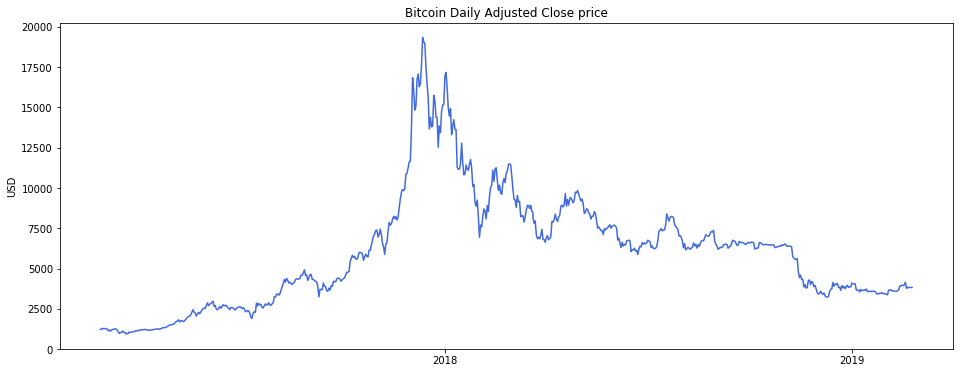

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 6.0
plt.plot(rawdata.index, rawdata['Adj Close'], color='royalblue')
plt.title('Bitcoin Daily Adjusted Close price')
#plt.xlabel('Year')
plt.ylabel('USD')
plt.xticks([309, 674 ], ('2018', '2019') ) 
plt.show()

## 2. Data Preprocessing
### 2.1 Scale features
The input and output data that go into model need to be scaled. Use preprocessing.MinMaxScaler() function in scikit-learn library to scale data to the range of 0-1.
#### Scaled data

In [7]:
data=rawdata.copy()

In [8]:
'Date','High','Low','Open','Close','Volume','Pct change','Adj Close'

('Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Pct change', 'Adj Close')

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

data['High'] = min_max_scaler.fit_transform(data['High'].values.reshape(-1,1))
data['Low'] = min_max_scaler.fit_transform(data['Low'].values.reshape(-1,1))
data['Open'] = min_max_scaler.fit_transform(data['Open'].values.reshape(-1,1))
data['Close'] = min_max_scaler.fit_transform(data['Close'].values.reshape(-1,1))
data['Volume'] = min_max_scaler.fit_transform(data['Volume'].values.reshape(-1,1))
data['Pct change'] = min_max_scaler.fit_transform(data['Pct change'].values.reshape(-1,1))
data['Adj Close'] = min_max_scaler.fit_transform(data['Adj Close'].values.reshape(-1,1))

data.head()

C:\Users\jangn\AppData\Local\Enthought\Canopy\edm\envs\Default_Python3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,High,Low,Open,Close,Volume,Pct change,Adj Close
Date,,,,,,,
2017-03-01,0.012137,0.017478,0.013559,0.015373,0.006335,0.468336,0.015373
2017-03-02,0.015419,0.020684,0.015372,0.017156,0.012132,0.465435,0.017156
2017-03-03,0.015650,0.022852,0.017155,0.018668,0.010178,0.454528,0.018668
2017-03-04,0.015355,0.021620,0.018667,0.017637,0.004187,0.368171,0.017637
2017-03-05,0.014693,0.022366,0.017636,0.018012,0.001537,0.415483,0.018012


### 2.2 Split data to training set and test set
Split data into training (80%) and test sets (20%). 

In [10]:
data = data.as_matrix()
df = []
for index in range(len(data) - 31):
    df.append(data[index: index + 31])
df = np.array(df)

C:\Users\jangn\AppData\Local\Enthought\Canopy\edm\envs\Default_Python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [11]:
splitRow = round(0.80 * df.shape[0])

## Training (80%)
train = df[:int(splitRow), :]
X_train = train[:, :-1] # all data until day 30
y_train = train[:, -1][:,-1] # day 31 close price
print('Training set:', train.shape[0], 'obs')

## Test (20%)
test = df[int(splitRow):, :]
X_test = test[:, :-1] # all data until day 30
y_test = test[:, -1][:,-1] # day 31 close price
print('Test set:', test.shape[0], 'obs')

Training set: 560 obs
Test set: 140 obs


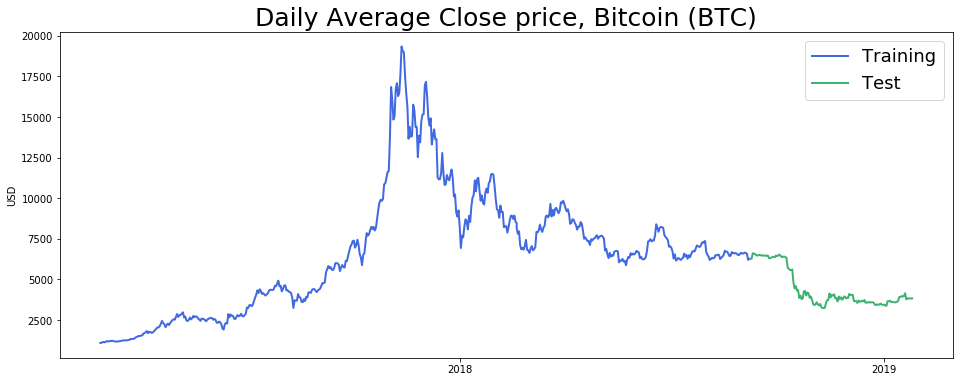

In [12]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 6.0
rawtrain = rawdata.iloc[31:591]
rawtest = rawdata.iloc[591:731]
plt.plot(rawtrain.index, rawtrain['Adj Close'], color='royalblue', label='Training', linewidth = 2)
plt.plot(rawtest.index, rawtest['Adj Close'], color='mediumseagreen', label='Test', linewidth = 2)
plt.xticks([309, 674 ], ('2018', '2019') )
plt.legend(loc='upper right', fontsize=18)
plt.title('Daily Average Close price, Bitcoin (BTC)', fontsize=25)
#plt.xlabel('Day')
plt.ylabel('USD')
plt.show()

## 3. Modeling
Now predict the close price for day $m$ based on data observed in the past 30 days $\{m-30, m-29, ...m-1\}$.

### 3.1 Define Network
Define a Sequential Model and add:

input layer with dimension (30, 7);
two LSTM layers with 256 neurons;
one hidden layers with 32 neurons with 'Relu';
one linear output layer.

In [13]:
model = Sequential()

decay = 0.5
epochs = 90

model.add(LSTM(256, input_shape=(30, 7), return_sequences=True)) # returns a sequence of vectors of dimension 256

model.add(Dropout(0.3))

model.add(LSTM(256, input_shape=(30, 7), return_sequences=False)) # returns a sequence of vectors of dimension 256
model.add(Dropout(0.3))

model.add(Dense(32,kernel_initializer="uniform",activation='relu')) # return a single vector of dimension 32

model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 256)           270336    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 803,905
Trainable params: 803,905
Non-trainable params: 0
_________________________________________________________________


### 3.2 Compile Network
Before training, configure the learning process by specifying:

Optimizer to be 'adam';

Loss function to be 'mse';

Evaluation metric to be 'accuracy'.

In [14]:
adam = keras.optimizers.Adam(decay=decay)
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

### 3.3 Train Network
Fit the model to training data to learn the parameters. (Training time 10+ minutes on a CPU)

In [15]:
history = model.fit(X_train, y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2, 
    verbose=0)

### 3.4 Evaluate Network
Evaluate model on the test set

In [16]:
mse, acc = model.evaluate(X_test, y_test)
print("mean square error = ", mse)

140/140 [==============================] - 0s 3ms/step
mean square error =  0.000443197710722


## 4. Results
The model shows that LSTM can capture the pattern of Bitcoin prices. However, there are some gaps between predicted and true movements. The performance can certainly be improve by further tuning the model, but the assumption of the stable status in stock market mechanism makes it hard to get significantly better results.


In [17]:
type(y_test)

numpy.ndarray

In [18]:
pred = model.predict(X_test)
pred = min_max_scaler.inverse_transform(pred)

y_test = np.asarray(y_test) #Make y_test into array in order to do reshape below
y_test = y_test.reshape(-1, 1)
y_test = min_max_scaler.inverse_transform(y_test)

y_test = [i[0] for i in y_test]
pred = [i[0] for i in pred]

respred = rawtest.copy()
respred['Adj Close'] = pred

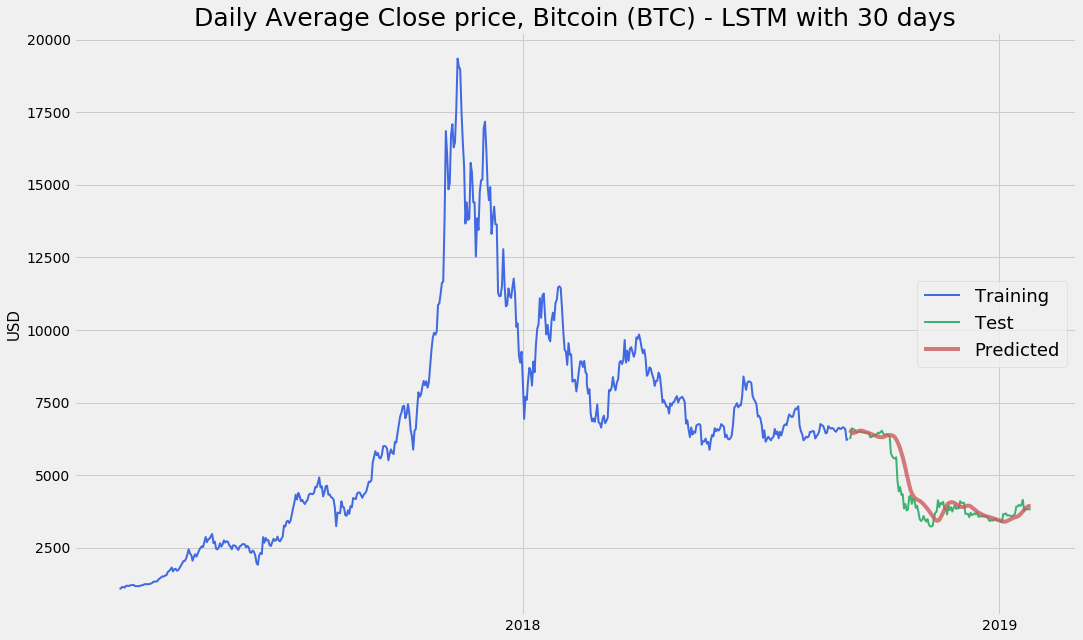

In [19]:
import pylab
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 10.0
plt.style.use('fivethirtyeight')
plt.plot(rawtrain.index, rawtrain['Adj Close'], color='royalblue', label='Training', linewidth = 2)
plt.plot(rawtest.index, rawtest['Adj Close'], color='mediumseagreen', label='Test', linewidth = 2)
plt.plot(rawtest.index, respred['Adj Close'], color='indianred', label='Predicted', linewidth = 4, alpha=0.8)
plt.xticks([309, 674 ], ('2018', '2019') )
plt.legend(loc='center right', fontsize=18)
plt.title('Daily Average Close price, Bitcoin (BTC) - LSTM with 30 days', fontsize=25)
#plt.xlabel('Day')
plt.ylabel('USD', fontsize=15)

pylab.savefig('Bitcoin.jpg')
pylab.savefig('Bitcoin.pdf')
plt.show()